In [127]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from skimage import io, transform
import os
from PIL import Image

In [128]:
print(torch.cuda.is_available())

True


In [129]:
labels = pd.read_csv('flower_classification/training_label.csv')
print(labels)
print(len(labels))
print(labels.index)
print(labels.iloc[0, 1])
print(type(labels.iloc[0, 1]))
# print(os.listdir('flower_classification/training'))

               Id  Category
0     image_02306        41
1     image_06792        21
2     image_05094         2
3     image_02812        56
4     image_03737        37
...           ...       ...
5995  image_06372        15
5996  image_01744        83
5997  image_04118        29
5998  image_00859        81
5999  image_05460        87

[6000 rows x 2 columns]
6000
RangeIndex(start=0, stop=6000, step=1)
41
<class 'numpy.int64'>


5000
(tensor([[[-0.2549, -0.3176, -0.3098,  ..., -0.8510, -0.8275, -0.8902],
         [-0.4588, -0.2235, -0.3647,  ..., -0.8353, -0.8196, -0.8667],
         [-0.8118, -0.4431, -0.2784,  ..., -0.9059, -0.8667, -0.8431],
         ...,
         [-0.5451, -0.6627, -0.7333,  ..., -0.9373, -0.9294, -0.9216],
         [-0.7333, -0.6706, -0.5922,  ..., -0.8588, -0.8980, -0.8980],
         [-0.8667, -0.6471, -0.5686,  ..., -0.7882, -0.8902, -0.8667]],

        [[-0.7176, -0.6235, -0.6863,  ..., -0.7804, -0.7804, -0.7725],
         [-0.7098, -0.7098, -0.6706,  ..., -0.7647, -0.7490, -0.7647],
         [-0.7255, -0.7882, -0.8588,  ..., -0.7961, -0.7725, -0.7412],
         ...,
         [-0.3725, -0.4588, -0.5059,  ..., -0.7882, -0.7647, -0.7490],
         [-0.6235, -0.4667, -0.4039,  ..., -0.6863, -0.7255, -0.7098],
         [-0.8902, -0.4902, -0.3804,  ..., -0.6157, -0.7412, -0.7176]],

        [[-0.6627, -0.7647, -0.8824,  ..., -0.9843, -0.9765, -0.9765],
         [-0.7882, -0.7176, -0.8118,  .

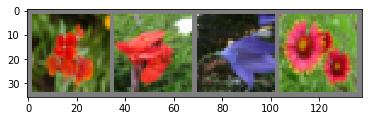

46 90 19 100


In [130]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((.5,.5,.5), (.5,.5,.5))])

csv_fname = 'flower_classification/training_label.csv'

img_list = pd.read_csv(csv_fname)

train_images = []
train_labels = []

test_images = []
test_labels = []

main_dir = 'flower_classification/training/'
for i in range(len(img_list)):
    if i < 5000:
        train_images.append(Image.open(main_dir + img_list.iloc[i, 0] + '.jpg'))
        train_labels.append(img_list.iloc[i, 1])
    else:
        test_images.append(Image.open(main_dir + img_list.iloc[i, 0] + '.jpg'))
        test_labels.append(img_list.iloc[i, 1])

class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform
#         all_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
#         img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
#         image = Image.open(img_loc).convert("RGB")
#         tensor_image = self.transform(image)
#         if (torch.is_tensor(idx)):
#             idx = idx.tolist()
#         img_name = os.path.join(self.main_dir, self.labels.iloc[idx, 0] + '.jpg')
# #         image = io.imread(img_name)
#         image = Image.open(img_name)
        image = self.images[idx]
        image_label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        return image, image_label

trainset = CustomDataSet(train_images, train_labels, transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True)

testset = CustomDataSet(test_images, test_labels, transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = True)

print(len(trainset))
print(trainset[0])
print(type(trainset[0][0]))
print(trainset[0][0].shape)

# for i, dat in enumerate(dataset_loader):
#     print(dat)
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training image
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%d' % labels[j] for j in range(4)))
# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                        download=True, transform=transform)

# trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
#                                          shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='.data', train=False,
#                                       download=True, transform=transform)

# testloader = torch.utils.data.DataLoader(testset, batch_size=4,
#                                         shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
#           'horse', 'ship', 'truck')

In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 400, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(400, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 103)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 400, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(400, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=103, bias=True)
)


In [132]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [133]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data[0].cuda(), data[1].cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # foreward, backward and optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 500 == 499:  # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0

[1,   500] loss: 1.137
[1,  1000] loss: 1.049
[2,   500] loss: 0.917
[2,  1000] loss: 0.879


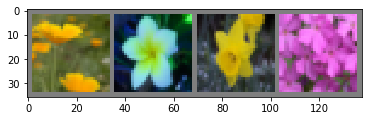

GroundTruth:  65 81 42 32


In [134]:
dataiter = iter(testloader)
data = dataiter.next()
images, labels = data[0].cuda(), data[1].cuda()

# print images
cpu_images = images.cpu()
imshow(torchvision.utils.make_grid(cpu_images))
print('GroundTruth: ', ' '.join('%d' % labels[j] for j in range(4)))

In [135]:
outputs = net(images)
print(outputs)
_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%d' % predicted[j]
                              for j in range(4)))

tensor([[-2.1833, -1.0914, -1.4922,  0.3555, -0.5817,  0.9532,  1.3785, -0.9862,
          2.5821, -2.0534,  0.2271,  1.0399,  2.4834, -0.8505,  1.3788,  2.8378,
          1.6088, -0.1590,  1.0347, -1.3227, -0.4019,  1.8183, -1.2475,  0.1256,
          0.1169, -0.1040, -0.6718, -0.7859, -0.4189, -2.4223, -0.9765, -0.5080,
         -1.6299,  1.2401, -1.5468,  0.3652, -3.2158, -1.1903,  0.1912, -1.8955,
          0.9741,  1.0994,  2.2180,  0.7714, -1.6508, -0.8980,  0.8479,  1.5562,
          2.3722,  0.8119,  0.5585,  0.9531,  0.5116,  2.0881,  3.8110, -0.9837,
         -1.8471, -1.0981, -2.1008, -0.6992,  0.3070,  1.1601, -1.3588,  1.6936,
         -1.0337,  2.2258, -3.0162, -0.4772,  0.6180, -1.1828, -0.1896,  1.5352,
         -1.3812, -0.6654, -0.0565, -1.1517, -1.5130,  0.7422, -1.1960, -0.2519,
         -1.0403,  2.2400, -1.0322,  0.5223,  0.7794, -1.5964, -1.9885,  0.5283,
         -1.3993,  0.6275,  1.3855,  0.1783, -0.2269, -1.0536, -0.2201,  0.0391,
          0.1212,  0.8194, -

In [136]:
correct = 0
total = 0
for data in testloader:
    images, labels = data[0].cuda(), data[1].cuda()
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()
    
print('Accuracy of the network on the 5000 test images: %d %%' % (
100 * correct / total))

Accuracy of the network on the 5000 test images: 13 %
